In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWX5.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,42.639999,42.700001,42.349998,42.639999,35.164452,1108600
1,1/3/2013,42.380001,42.560001,42.200001,42.259998,34.851074,273200
2,1/4/2013,42.240002,42.520000,42.150002,42.490002,35.040752,297200
3,1/7/2013,42.080002,42.259998,42.070000,42.200001,34.801601,258700
4,1/8/2013,42.090000,42.090000,41.810001,41.919998,34.570686,90400


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 2.910000.3, cost: -33752.183594, total money: 10002.910000
epoch: 20, total rewards: -1.620014.3, cost: -33997.257812, total money: 9998.379986
epoch: 30, total rewards: -8.620010.3, cost: -34010.855469, total money: 9991.379989
epoch: 40, total rewards: 2.339989.3, cost: -33647.417969, total money: 10002.339989
epoch: 50, total rewards: 44.179996.3, cost: -32406.005859, total money: 9804.109993
epoch: 60, total rewards: 56.799988.3, cost: -31337.816406, total money: 8469.679989
epoch: 70, total rewards: 44.859981.3, cost: -31417.816406, total money: 8085.269981
epoch: 80, total rewards: 79.039970.3, cost: -31077.468750, total money: 7235.179962
epoch: 90, total rewards: 78.229969.3, cost: -30851.300781, total money: 7092.739971
epoch: 100, total rewards: 68.109974.3, cost: -30865.507812, total money: 6763.659977
epoch: 110, total rewards: 95.379932.3, cost: -30779.857422, total money: 6562.599934
epoch: 120, total rewards: 127.299934.3, cost: -31167.525391, t

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 42.639999, total balance 9957.360001
day 2: buy 1 unit at price 42.490002, total balance 9914.869999
day 3: buy 1 unit at price 42.200001, total balance 9872.669998
day 6, sell 1 unit at price 42.669998, investment 0.070354 %, total balance 9915.339996,
day 7: buy 1 unit at price 42.700001, total balance 9872.639996
day 8: buy 1 unit at price 42.790001, total balance 9829.849995
day 12: buy 1 unit at price 42.869999, total balance 9786.979996
day 13: buy 1 unit at price 42.919998, total balance 9744.059998
day 14, sell 1 unit at price 42.790001, investment 0.706047 %, total balance 9786.849998,
day 15, sell 1 unit at price 42.849998, investment 1.540279 %, total balance 9829.699997,
day 16, sell 1 unit at price 43.180000, investment 1.124121 %, total balance 9872.879997,
day 19, sell 1 unit at price 43.279999, investment 1.145122 %, total balance 9916.159996,
day 22: buy 1 unit at price 42.750000, total balance 9873.409996
day 24, sell 1 unit at price 42.9700

day 249, sell 1 unit at price 46.330002, investment 3.972173 %, total balance 9097.959972,
day 250, sell 1 unit at price 46.459999, investment 2.357347 %, total balance 9144.419971,
day 252, sell 1 unit at price 45.770000, investment -0.043679 %, total balance 9190.189972,
day 256, sell 1 unit at price 45.790001, investment -0.217909 %, total balance 9235.979973,
day 259: buy 1 unit at price 45.790001, total balance 9190.189972
day 261: buy 1 unit at price 46.150002, total balance 9144.039970
day 262: buy 1 unit at price 46.150002, total balance 9097.889969
day 263, sell 1 unit at price 45.970001, investment -0.819843 %, total balance 9143.859970,
day 264: buy 1 unit at price 46.080002, total balance 9097.779968
day 265, sell 1 unit at price 46.150002, investment -1.008145 %, total balance 9143.929970,
day 266, sell 1 unit at price 45.720001, investment -2.098500 %, total balance 9189.649971,
day 267, sell 1 unit at price 44.529999, investment -4.030178 %, total balance 9234.179970,
da

day 517, sell 1 unit at price 43.549999, investment -1.825972 %, total balance 9598.029957,
day 518: buy 1 unit at price 43.349998, total balance 9554.679958
day 520: buy 1 unit at price 43.759998, total balance 9510.919960
day 521: buy 1 unit at price 43.130001, total balance 9467.789959
day 522, sell 1 unit at price 43.549999, investment -0.183364 %, total balance 9511.339958,
day 525, sell 1 unit at price 44.169998, investment 3.904963 %, total balance 9555.509956,
day 528, sell 1 unit at price 43.740002, investment 0.899661 %, total balance 9599.249958,
day 529, sell 1 unit at price 43.619999, investment -0.251545 %, total balance 9642.869957,
day 530: buy 1 unit at price 43.869999, total balance 9598.999958
day 531, sell 1 unit at price 43.599998, investment 0.137799 %, total balance 9642.599957,
day 532, sell 1 unit at price 44.330002, investment 3.045098 %, total balance 9686.929958,
day 533, sell 1 unit at price 44.669998, investment 5.155364 %, total balance 9731.599957,
day 5

day 683: buy 1 unit at price 40.180000, total balance 9922.689957
day 684, sell 1 unit at price 40.160000, investment -0.396825 %, total balance 9962.849957,
day 686: buy 1 unit at price 38.910000, total balance 9923.939957
day 687: buy 1 unit at price 38.840000, total balance 9885.099957
day 690: buy 1 unit at price 38.240002, total balance 9846.859955
day 693, sell 1 unit at price 39.910000, investment -2.989790 %, total balance 9886.769955,
day 694, sell 1 unit at price 40.740002, investment 1.393732 %, total balance 9927.509956,
day 695, sell 1 unit at price 40.810001, investment 4.883067 %, total balance 9968.319958,
day 696: buy 1 unit at price 41.389999, total balance 9926.929958
day 699: buy 1 unit at price 41.730000, total balance 9885.199959
day 702, sell 1 unit at price 42.080002, investment 8.341920 %, total balance 9927.279961,
day 704: buy 1 unit at price 41.840000, total balance 9885.439960
day 706, sell 1 unit at price 41.500000, investment 8.525100 %, total balance 992

day 991, sell 1 unit at price 40.970001, investment -0.097530 %, total balance 9519.189968,
day 992, sell 1 unit at price 41.009998, investment -0.170408 %, total balance 9560.199966,
day 993, sell 1 unit at price 41.090000, investment 0.883871 %, total balance 9601.289967,
day 994, sell 1 unit at price 40.959999, investment 0.614100 %, total balance 9642.249966,
day 996, sell 1 unit at price 40.660000, investment 1.345964 %, total balance 9682.909965,
day 997: buy 1 unit at price 40.599998, total balance 9642.309967
day 998: buy 1 unit at price 40.520000, total balance 9601.789967
day 999: buy 1 unit at price 40.439999, total balance 9561.349968
day 1002: buy 1 unit at price 39.970001, total balance 9521.379967
day 1005: buy 1 unit at price 39.990002, total balance 9481.389965
day 1006: buy 1 unit at price 40.259998, total balance 9441.129967
day 1007: buy 1 unit at price 40.270000, total balance 9400.859966
day 1009, sell 1 unit at price 40.939999, investment 3.566911 %, total balanc

day 1183: buy 1 unit at price 48.090000, total balance 8281.599968
day 1184: buy 1 unit at price 48.209999, total balance 8233.389969
day 1185, sell 1 unit at price 48.290001, investment 10.125434 %, total balance 8281.679970,
day 1186: buy 1 unit at price 48.360001, total balance 8233.319969
day 1187, sell 1 unit at price 48.549999, investment 11.225653 %, total balance 8281.869968,
day 1188, sell 1 unit at price 48.500000, investment 11.596873 %, total balance 8330.369968,
day 1189: buy 1 unit at price 48.419998, total balance 8281.949970
day 1191: buy 1 unit at price 48.080002, total balance 8233.869968
day 1192: buy 1 unit at price 47.970001, total balance 8185.899967
day 1193, sell 1 unit at price 47.950001, investment 10.892689 %, total balance 8233.849968,
day 1194: buy 1 unit at price 48.009998, total balance 8185.839970
day 1195, sell 1 unit at price 48.349998, investment 10.919932 %, total balance 8234.189968,
day 1200: buy 1 unit at price 48.540001, total balance 8185.649967

day 1335: buy 1 unit at price 50.110001, total balance 7977.119965
day 1336: buy 1 unit at price 49.900002, total balance 7927.219963
day 1338: buy 1 unit at price 50.110001, total balance 7877.109962
day 1341: buy 1 unit at price 49.799999, total balance 7827.309963
day 1342: buy 1 unit at price 49.689999, total balance 7777.619965
day 1345: buy 1 unit at price 49.930000, total balance 7727.689964
day 1348, sell 1 unit at price 50.619999, investment 2.573456 %, total balance 7778.309963,
day 1349, sell 1 unit at price 50.680000, investment 2.695039 %, total balance 7828.989964,
day 1351: buy 1 unit at price 50.270000, total balance 7778.719963
day 1352: buy 1 unit at price 50.520000, total balance 7728.199963
day 1353, sell 1 unit at price 50.410000, investment 2.501016 %, total balance 7778.609962,
day 1354: buy 1 unit at price 50.150002, total balance 7728.459961
day 1355: buy 1 unit at price 50.490002, total balance 7677.969959
day 1356: buy 1 unit at price 50.470001, total balance

day 1623, sell 1 unit at price 45.980000, investment -3.159225 %, total balance 6764.369972,
day 1624, sell 1 unit at price 45.250000, investment -2.436397 %, total balance 6809.619972,
day 1626: buy 1 unit at price 46.320000, total balance 6763.299973
day 1627, sell 1 unit at price 46.849998, investment -0.825578 %, total balance 6810.149971,
day 1629, sell 1 unit at price 46.730000, investment -2.949121 %, total balance 6856.879971,
day 1630, sell 1 unit at price 46.330002, investment -3.176587 %, total balance 6903.209972,
day 1631, sell 1 unit at price 46.490002, investment -3.306989 %, total balance 6949.699974,
day 1633: buy 1 unit at price 46.759998, total balance 6902.939976
day 1636: buy 1 unit at price 47.360001, total balance 6855.579975
day 1637: buy 1 unit at price 47.049999, total balance 6808.529976
day 1638, sell 1 unit at price 46.740002, investment -2.766794 %, total balance 6855.269978,
day 1640, sell 1 unit at price 46.830002, investment -1.035498 %, total balance 6

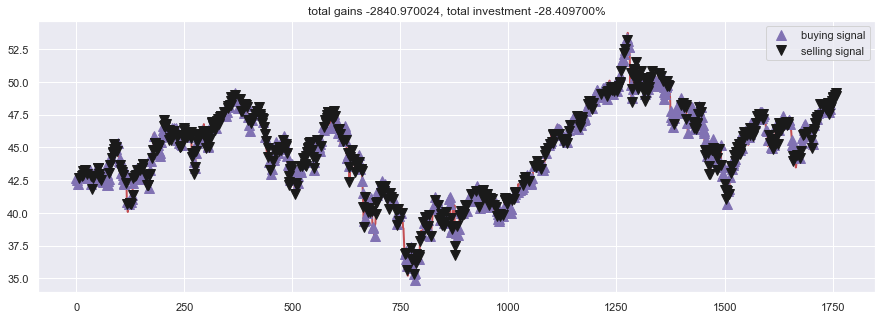

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()